In [1]:
%matplotlib inline
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
import json
import csv
import pandas as pd
import sklearn.feature_extraction.text as sk_text
import io
import requests
import numpy as np
import time
from scipy.stats import zscore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from IPython.display import display
from matplotlib.pyplot import figure

#-----------------------------PROFESSOR'S CODE---------------------------------------
# Plot a confusion matrix.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#-----------------------------PROFESSOR'S CODE---------------------------------------
# Plot a coefficient chart.
def report_coef(names,coef,intercept):
    plt.figure(figsize=(18,27))
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    plt.figure(figsize=(8,6))

#------------------PROFESSOR'S CODE, HIDDEN GEM--------------------------
#We modified this to make it more powerful, full dataframe normalization
def encode_numeric_range(df, list, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    for i in range (0,len(list)):
        if data_low is None:
            data_low = min(df[list[i]])
            data_high = max(df[list[i]])
        df[list[i]] = ((df[list[i]] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low
        data_low=None

#fix headers for census data
def fix_table(df,dropig=True):
    new_header = df.iloc[0]
    df = df[1:]
    df.columns = new_header
    df = df.astype({"Id2" : int})
    if dropig:
        df = df.drop(['Id','Geography'],axis=1)
    return df

In [2]:
dp1  = pd.read_csv('census_data/DEC_00_110H_DP1_with_ann.csv', encoding="utf-8")
dp2  = pd.read_csv('census_data/DEC_00_110S_DP2_with_ann.csv', encoding="utf-8")
dp3  = pd.read_csv('census_data/DEC_00_110S_DP3_with_ann.csv', encoding="utf-8")
dp4  = pd.read_csv('census_data/DEC_00_110S_DP4_with_ann.csv', encoding="utf-8")
h002 = pd.read_csv('census_data/DEC_00_110H_H002_with_ann.csv', encoding="utf-8")
res  = pd.read_csv('census_data/election_results.csv', encoding="utf-8")

#fix headers
dp1  = fix_table(dp1,False)
dp2  = fix_table(dp2)
dp3  = fix_table(dp3)
dp4  = fix_table(dp4)
h002 = fix_table(h002)
res  = fix_table(res)

df = dp1.copy()
df = df.merge(dp2,on="Id2")
df = df.merge(dp3,on="Id2")
df = df.merge(dp4,on="Id2")
df = df.merge(h002,on="Id2")
df = df.merge(res,on="Id2")

#fix typo in header
df.rename(columns={'Rural' : 'Rural:'},inplace=True)

#Cleaning useless columns
df.drop('Id', axis=1, inplace=True)
df.drop('Id2', axis=1, inplace=True)
df.drop('Geography', axis=1, inplace=True)
df.drop('Not defined for this file', axis=1, inplace=True)
nunique = df.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis=1,inplace=True)
df.drop(list(df.filter(regex = 'Percent;')), axis = 1, inplace = True)

In [3]:
#--------------------ONLY NEED TO DO THIS ONCE--------------------
#code to remove screwed up invalid utf-8 chars
with open('census_data/house_results.csv', 'rb') as f:
    ftxt = f.read().decode('utf-8', 'ignore')
with open('census_data/house_results.csv', 'w') as f:
    f.write(ftxt)

In [140]:
#get precent votes for `06 election
hres = pd.read_csv('census_data/house_results.csv', encoding="utf-8")
#remove non `06 results
hres = hres.loc[hres['year'] == 2006]
hres = hres.loc[hres['stage'] == 'gen']
hres = hres.sort_values(by=['state', 'district'])
hres = hres.astype({'candidatevotes' : float, 'totalvotes' : float})
hres = hres.loc[:,hres.columns.isin(['state','district', 'party', 'candidatevotes', 'totalvotes'])]

#get the total votes
dVotes = hres.loc[hres['party']=='democrat']
rVotes = hres.loc[hres['party']=='republican']
dVotes = dVotes.assign(dVotePct= dVotes['candidatevotes'] / dVotes['totalvotes'])
rVotes = rVotes.assign(rVotePct= rVotes['candidatevotes'] / rVotes['totalvotes'])

hres = dVotes.copy()
hres = hres.merge(rVotes, on=['state', 'district'])
hres=hres.rename(columns={'candidatevotes_x':'dVoteCnt','candidatevotes_y':'rVoteCnt','totalvotes_x':'tvotes'})

#at this point we have the votes in a table, now to merge it into the big table above
#I decided that the best way to do this is by calculating each states census id and then joining the tables
stateSeq = hres.groupby(by="state").first()
stateSeq = stateSeq.reset_index()
stateSeq = stateSeq.assign(indx=stateSeq['state'].index+1)

#there are some gaps (caused by territories) that causes the house results to be unalligned w/ the census
for i in (3,7,11,14,43,52):
    stateSeq['indx'] = stateSeq['indx'].apply(lambda x: x+1 if x>=i else x)

#cleanup the house results table & remove no longer needed columns
stateSeq = stateSeq.loc[:,stateSeq.columns.isin(['state','indx'])]
hres = hres.merge(stateSeq,on='state')
hres = hres.assign(Id2=hres['indx']*100+hres['district'])
hres = hres.loc[:,hres.columns.isin(['dVotePct','rVotePct','Id2','dVoteCnt', 'rVoteCnt', 'tvotes'])]
hres = hres.astype({'dVoteCnt':'int','rVoteCnt':'int','tvotes':'int'})
hres

In [4]:
columnnames = list(df.columns)
print('\n'.join(map(str, columnnames)))

Number; Total population
Number; Total population - SEX AND AGE - Male
Number; Total population - SEX AND AGE - Female
Number; Total population - SEX AND AGE - Under 5 years
Number; Total population - SEX AND AGE - 5 to 9 years
Number; Total population - SEX AND AGE - 10 to 14 years
Number; Total population - SEX AND AGE - 15 to 19 years
Number; Total population - SEX AND AGE - 20 to 24 years
Number; Total population - SEX AND AGE - 25 to 34 years
Number; Total population - SEX AND AGE - 35 to 44 years
Number; Total population - SEX AND AGE - 45 to 54 years
Number; Total population - SEX AND AGE - 55 to 59 years
Number; Total population - SEX AND AGE - 60 to 64 years
Number; Total population - SEX AND AGE - 65 to 74 years
Number; Total population - SEX AND AGE - 75 to 84 years
Number; Total population - SEX AND AGE - 85 years and over
Number; Total population - SEX AND AGE - Median age (years)
Number; Total population - SEX AND AGE - 18 years and over
Number; Total population - SEX AND

In [5]:
#Encodes Democrat and Republican winners in a 2d array in 'outputs' this will go to our classification model
#Encodes Democrat Winners as 1 and Republican winners as 0 in a 1d array in 'winners' this will go to the logistic regression model for feature importance
winners = df.filter(['winner'])
encoder = preprocessing.LabelBinarizer()
encoder.fit(['D','R'])
winners['result'] = encoder.transform(winners['winner'])
winners['result'] = np.logical_xor(winners['result'],1).astype(int)
winners.drop('winner', axis=1, inplace=True)
outputs = winners.copy()
outputs.columns = ['Democrat']
outputs['Republican'] = np.logical_xor(outputs['Democrat'],1).astype(int)
df.drop('winner', axis=1, inplace=True)
outputs

,Democrat,Republican
0,0,1
1,0,1
2,0,1
3,0,1
4,1,0
5,0,1
6,1,0
7,0,1
8,0,1
9,0,1


In [5]:
#Check dataframe for NAN values
df.isnull().sum().sum()

0

In [6]:
#fix column types
df=df.astype(float)
#normalize dataframe
encode_numeric_range(df, list(df.columns), 0, 1)
df

,Number; Total population,Number; Total population - SEX AND AGE - Male,Number; Total population - SEX AND AGE - Female,Number; Total population - SEX AND AGE - Under 5 years,Number; Total population - SEX AND AGE - 5 to 9 years,Number; Total population - SEX AND AGE - 10 to 14 years,Number; Total population - SEX AND AGE - 15 to 19 years,Number; Total population - SEX AND AGE - 20 to 24 years,Number; Total population - SEX AND AGE - 25 to 34 years,Number; Total population - SEX AND AGE - 35 to 44 years,...,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 20 to 24 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 25 to 29 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 30 to 34 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 35 percent or more,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - Not computed,Total:,Urban:,Urban: - Inside urbanized areas,Urban: - Inside urban clusters,Rural:
0,0.346507,0.289628,0.401684,0.361375,0.500343,0.559825,0.429037,0.271253,0.230556,0.296505,...,0.120014,0.116077,0.103110,0.145708,0.513885,0.494311,0.367890,0.365028,0.282223,0.367448
1,0.346507,0.298007,0.393556,0.315595,0.450421,0.531563,0.410553,0.310724,0.274024,0.294669,...,0.130174,0.113715,0.117802,0.126617,0.652806,0.492763,0.238877,0.223865,0.368536,0.501493
2,0.346507,0.285809,0.405389,0.290408,0.426490,0.486890,0.489440,0.467572,0.248126,0.222964,...,0.113267,0.097180,0.104427,0.191515,0.676432,0.510991,0.284621,0.310398,0.247368,0.469839
3,0.346507,0.307823,0.384034,0.293211,0.399417,0.461522,0.359053,0.227540,0.255317,0.261872,...,0.040679,0.055464,0.020424,0.030845,0.654987,0.498463,0.039848,0.086508,0.302058,0.715549
4,0.346507,0.304914,0.386856,0.302281,0.439954,0.501572,0.378713,0.262461,0.279631,0.419574,...,0.154145,0.133699,0.129661,0.124718,0.462489,0.482699,0.345956,0.402692,0.143816,0.380046
5,0.346507,0.307629,0.384222,0.300354,0.406846,0.490055,0.323563,0.236487,0.331641,0.418070,...,0.096519,0.070960,0.039399,0.050411,0.355627,0.453842,0.347591,0.421396,0.100731,0.352419
6,0.346507,0.234404,0.455257,0.366319,0.483196,0.535603,0.511379,0.458068,0.249822,0.209890,...,0.199905,0.169840,0.236856,0.288970,0.771009,0.495729,0.456871,0.506981,0.111991,0.275310
7,0.326018,0.376607,0.276942,0.421792,0.625304,0.736811,0.480875,0.258080,0.300817,0.558503,...,0.233401,0.210375,0.231519,0.173906,0.742076,0.414319,0.308778,0.295344,0.334194,0.357676
8,0.361269,0.383584,0.339622,0.366397,0.548580,0.680683,0.500837,0.297195,0.160113,0.187350,...,0.097670,0.092455,0.102912,0.128386,0.514830,0.541531,0.280561,0.141168,0.659171,0.501524
9,0.361269,0.324749,0.396697,0.291303,0.420268,0.472457,0.287538,0.133893,0.166460,0.177726,...,0.082986,0.090849,0.086441,0.101570,0.263885,0.517383,0.624354,0.514676,0.435771,0.118933


In [7]:
parties = list(outputs)
names = list(df)
print(parties)
print("\n")
print(names)

['Democrat', 'Republican']


['Number; Total population', 'Number; Total population - SEX AND AGE - Male', 'Number; Total population - SEX AND AGE - Female', 'Number; Total population - SEX AND AGE - Under 5 years', 'Number; Total population - SEX AND AGE - 5 to 9 years', 'Number; Total population - SEX AND AGE - 10 to 14 years', 'Number; Total population - SEX AND AGE - 15 to 19 years', 'Number; Total population - SEX AND AGE - 20 to 24 years', 'Number; Total population - SEX AND AGE - 25 to 34 years', 'Number; Total population - SEX AND AGE - 35 to 44 years', 'Number; Total population - SEX AND AGE - 45 to 54 years', 'Number; Total population - SEX AND AGE - 55 to 59 years', 'Number; Total population - SEX AND AGE - 60 to 64 years', 'Number; Total population - SEX AND AGE - 65 to 74 years', 'Number; Total population - SEX AND AGE - 75 to 84 years', 'Number; Total population - SEX AND AGE - 85 years and over', 'Number; Total population - SEX AND AGE - Median age (years)', 'Number; Tot

In [8]:
x = df.to_numpy('float32')
y = outputs.to_numpy('float32')
print(x.shape)
print(y.shape)

(436, 398)
(436, 2)


In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=(int(time.time()) % 1000))

In [10]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='relu'))
model.add(Dense(132, activation='relu'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor], verbose=2, epochs=100)

W1123 03:36:47.719601  5756 deprecation.py:506] From C:\Users\Randall\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 327 samples, validate on 109 samples
Epoch 1/100
327/327 - 1s - loss: 0.6617 - val_loss: 0.5436
Epoch 2/100
327/327 - 0s - loss: 0.5519 - val_loss: 0.4841
Epoch 3/100
327/327 - 0s - loss: 0.5753 - val_loss: 0.5120
Epoch 4/100
327/327 - 0s - loss: 0.5065 - val_loss: 0.4895
Epoch 5/100
327/327 - 0s - loss: 0.4838 - val_loss: 0.4556
Epoch 6/100
327/327 - 0s - loss: 0.4611 - val_loss: 0.4387
Epoch 7/100
327/327 - 0s - loss: 0.4465 - val_loss: 0.4304
Epoch 8/100
327/327 - 0s - loss: 0.4698 - val_loss: 0.4436
Epoch 9/100
327/327 - 0s - loss: 0.4321 - val_loss: 0.4476
Epoch 10/100
327/327 - 0s - loss: 0.4301 - val_loss: 0.4303
Epoch 11/100
327/327 - 0s - loss: 0.4186 - val_loss: 0.4220
Epoch 12/100
327/327 - 0s - loss: 0.4140 - val_loss: 0.4246
Epoch 13/100
327/327 - 0s - loss: 0.3918 - val_loss: 0.4248
Epoch 14/100
327/327 - 0s - loss: 0.3947 - val_loss: 0.4118
Epoch 15/100
327/327 - 0s - loss: 0.3935 - val_loss: 0.4244
Epoch 16/100
327/327 - 0s - loss: 0.3714 - val_loss: 0.4162
Epo

In [11]:
pred = model.predict(xtest)
for i in range(10):
    print("{}. Actual Party: {}\t\tPredicted Party: {}".format(i+1,parties[np.argmax(ytest[i])],parties[np.argmax(pred[i])]))

1. Actual Party: Republican		Predicted Pary: Democrat
2. Actual Party: Republican		Predicted Pary: Democrat
3. Actual Party: Republican		Predicted Pary: Republican
4. Actual Party: Republican		Predicted Pary: Democrat
5. Actual Party: Republican		Predicted Pary: Democrat
6. Actual Party: Democrat		Predicted Pary: Democrat
7. Actual Party: Democrat		Predicted Pary: Democrat
8. Actual Party: Republican		Predicted Pary: Republican
9. Actual Party: Democrat		Predicted Pary: Democrat
10. Actual Party: Republican		Predicted Pary: Republican


In [12]:
ytrue = np.argmax(ytest, axis=1)
p = np.argmax(pred, axis=1)

In [17]:
accuracy = metrics.accuracy_score(ytrue,p)
print("Accuracy score: {}".format(accuracy))
prec = metrics.precision_score(ytrue, p, average="weighted")
print("Precision score: {}".format(prec))
recall = metrics.recall_score(ytrue, p, average="weighted")
print("Recall score: {}".format(recall))
f1 = metrics.f1_score(ytrue, p, average="weighted")
print("F1 score: {}".format(f1))
print("\n\t\t\tCLASSIFICATION REPORT\n")
print(metrics.classification_report(ytrue, p))

Accuracy score: 0.7431192660550459
Precision score: 0.7911636890391115
Recall score: 0.7431192660550459
F1 score: 0.7327452364149611

			CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.67      0.94      0.78        54
           1       0.91      0.55      0.68        55

    accuracy                           0.74       109
   macro avg       0.79      0.74      0.73       109
weighted avg       0.79      0.74      0.73       109



[[51  3]
 [25 30]]


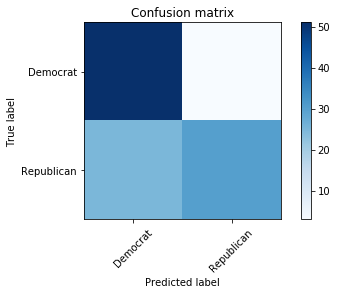

In [14]:
cm = confusion_matrix(ytrue, p)
print(cm)
plt.figure()
plot_confusion_matrix(cm, ['Democrat','Republican'])
plt.show()